# Audio feature extraction

This is a tutorial on spectral audio features commonly used in audio applications.

In [2]:
from __future__ import print_function, division
import os.path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import librosa as lb # module for audio feature extraction
import pylotwhale.utils.plotTools as pT

%matplotlib inline
plt.style.use('bmh')
matplotlib.rcParams.update({'font.size':18})


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Load an audio file

In [4]:
oDir = '/home/florencia/phd/PhDthesis/thesis/9_appendix/figures'
wavF = '/home/florencia/whales/data/Vocal-repertoire-catalogue-Pilot-whales-Norway/NPW-33/2009-07-13-J/NPW-033-J-B-090713_f50-8_00_03_29.wav'

## The waveform

Time series of sound

Amplitude of oscilation of air pressure waves

sampling rate:  48000 
waveform size: 55867
1.16389583333


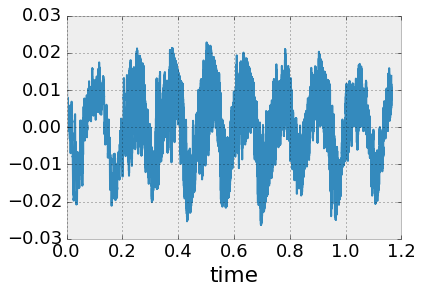

In [5]:
y, sr = lb.load(wavF, sr=None) # default sr=22050
print("sampling rate: ", sr, "\nwaveform size:", len(y))
tf = 1.*len(y)/sr
print(tf)
#lb.display.waveplot(y, sr=sr)
plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, tf, len(y)), y)
#plt.ylabel('amplitude')
plt.xlabel('time')

oFig = os.path.join(oDir, 'wavefrorm.png')
plt.savefig(oFig, bbox_inches='tight')

### Power spectrum of the signal

with the fft
```
y_fft = np.fft.rfft(y)
Pxx_den = y_fft*y_fft
plt.plot(np.log(Pxx_den))```

or as a periodogram, te spectrum looks the same when the window is the full waveform

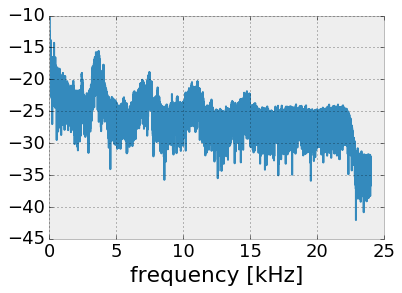

In [24]:
import scipy.signal as sig

f, Pxx_den = sig.welch(y, sr, nperseg=len(y))
plt.figure(figsize=(6,4))

plt.plot(f/1000, np.log(Pxx_den))
plt.xlabel('frequency [kHz]')
oFig = os.path.join(oDir, 'logSpectrum.png')
plt.savefig(oFig, bbox_inches='tight')


In [55]:
NFFT = 2**9
overlap = 0.5
spec_y, n_fft = lb.core.spectrum._spectrogram(y, n_fft=NFFT, 
                                              hop_length=int(NFFT*overlap))
nf, nt =  np.shape(spec_y)
print("#freqs:", nf, "\n#times:", nt, "\nNFFT:", n_fft)


#freqs: 257 
#times: 219 
NFFT: 512


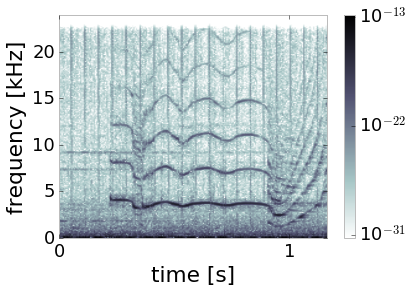

In [56]:
reload(pT)
matplotlib.rcParams['axes.grid']=False
fig, ax = pT.plspectro(y, sr, spec_fac=0.99999999)
bN = os.path.basename(wavF)
oFig = os.path.join(oDir, 'spectrogram.png')
fig.savefig(oFig, bbox_inches='tight')
#fig.clf()

### Mel spectrum

A scaled version of the spectrogram that resembles sound perception.
Prioritises lower frequencies.
A mapping between the linear frequencies in [Hz] into the Mel scale can be obtained with
$$
M(f) = 1125 \ln (1 + f/700)
$$

The Mel-spectrum can be computed applying a filter-bank over the spectrogram.

For that we create the **Mel-filterbank** to wrap the frequencies into the Mel-scale.


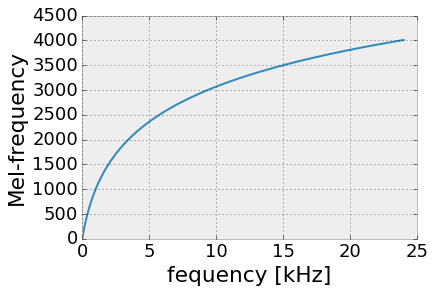

In [6]:
a = 1125; b = 700

freq2mel = lambda x: a * np.log(1 + 1000*x/b)
x = np.linspace(0, sr/2000, 1000)

plt.plot(x, freq2mel(x))
plt.xlabel('fequency [kHz]')
plt.ylabel('Mel-frequency')
oFig = os.path.join(oDir, 'Mel-scale-map.png')
plt.savefig(oFig, bbox_inches='tight')

mel basis: (64, 257) 
spectrogram: (257, 219)


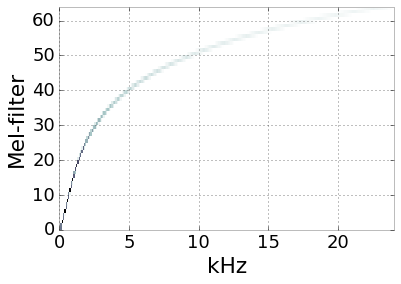

In [139]:
n_mels = 128/2
fmin=0
mel_basis = lb.filters.mel(sr, n_fft=NFFT, n_mels=n_mels, fmin=fmin)
print("mel basis:", np.shape(mel_basis), "\nspectrogram:", np.shape(spec_y))

matplotlib.rcParams['axes.grid']=True
plt.imshow(mel_basis, aspect='auto', cmap=plt.cm.bone_r, interpolation='nearest',
           origin='bottom', extent=(0, sr/2000, 0,n_mels))
plt.ylabel('Mel-filter')

plt.xlabel('kHz')

oFig = os.path.join(oDir, 'mel-filterbank.png')
#plt.savefig(oFig, bbox_inches='tight')

### The Mel-filters

The filters are scaled to have approximately constant energy.

The area under each filter is (approx.) constant

#mel filters : 10
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


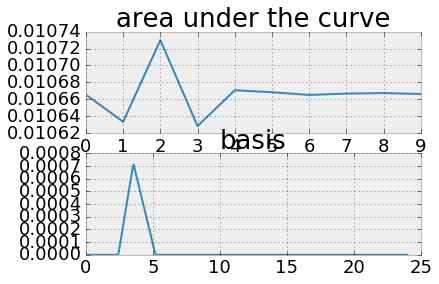

In [128]:
print("#mel filters :", len(mel_basis))
### Area of the mel filters
plt.subplot(2,1,1)
plt.title('area under the curve')
plt.plot([np.trapz(mel_basis[i,:]) for i in np.arange(len(mel_basis))]) # all filters

### plot filters
plt.subplot(2,1,2)
plt.title('basis')
plt.plot(np.linspace(0,sr/2000, np.shape(mel_basis)[1]), mel_basis[5,:])
#plt.plot(mel_basis[10,:])
#plt.plot(mel_basis[50,:])
#plt.plot(mel_basis[100,:])
#plt.plot(mel_basis[120,:])

print(mel_basis[9,10:25])

Applying the filterbank to the spectrum (not in log scale) we obtain the **Mel-spectrogram**

mel basis: (64, 257) 
spectrogram: (257, 219) 
mel-spectrum: (64, 219) 
NFFT: 512 
#mels: 64.0


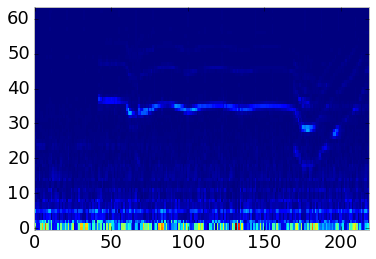

In [140]:
mel_spec_y = np.dot(mel_basis, spec_y) # matrix mutiplication

print("mel basis:", np.shape(mel_basis), "\nspectrogram:", np.shape(spec_y),
      "\nmel-spectrum:", np.shape(mel_spec_y), 
     "\nNFFT:", NFFT,
     "\n#mels:", n_mels,)
#     "\n#ceps:", n_mfcc)

matplotlib.rcParams['axes.grid']=False
plt.imshow(mel_spec_y, aspect='auto', origin='bottom', interpolation='nearest')

#### Now in log-scale

Because the n_fft determines the number of frequency channels in the spectrogram (=n_fft/2), when the the number of mel filters is close the n_fft is not posible to map the linear frequency into the Mel-scaled ones, especially at lower frquencies where more resolution is demanded.

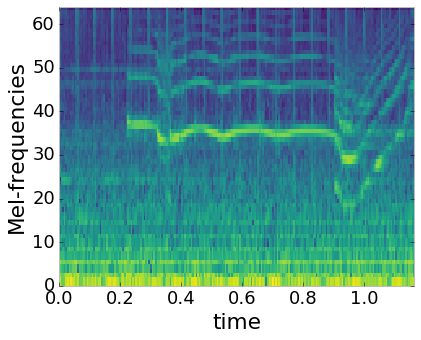

In [141]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
matplotlib.rcParams['axes.grid']=False
plt.imshow(np.log(mel_spec_y), aspect='auto', origin='bottom', interpolation='nearest',
          cmap=plt.cm.viridis, extent=[0, tf, 0, n_mels])
plt.xlabel('time')
plt.ylabel('Mel-frequencies')

oFig = os.path.join(oDir, 'mel-spectrum.png')
plt.savefig(oFig, bbox_inches='tight')

Using `lb.core.logamplitude` from libros we obtain the same

range (log): -5.35094289836 -11.5093856653 
range (lb-log amp): -23.2388497374 -49.9846268451


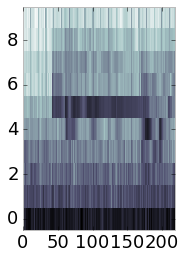

In [76]:
plt.subplot(1,2,2)
plt.imshow(lb.core.logamplitude(mel_spec_y), aspect='auto', origin='bottom', 
           interpolation='nearest', cmap=plt.cm.bone_r)

print('range (log):', np.max(np.log(mel_spec_y)), np.min(np.log(mel_spec_y)), 
      '\nrange (lb-log amp):',
      np.max(lb.core.logamplitude(mel_spec_y)), np.min(lb.core.logamplitude(mel_spec_y)))

#### Zero filters

Here we explore the relation between the NFFT and the n_mels.
At what point do we start having zeroing Mel-filters?
More or less around n_mels = NFFT/6

In [41]:
def myMelspec(y, sr, NFFT, n_mels=128, overlap=0):
    spec_y, n_fft = lb.core.spectrum._spectrogram(y, n_fft=NFFT, 
                                              hop_length=int(NFFT*overlap))
    mel_basis = lb.filters.mel(sr, n_fft=NFFT, n_mels=n_mels)#, fmin=1000)
    mel_spec_y = np.dot(mel_basis, spec_y) # matrix mutiplication
    return mel_spec_y
    
    
def hasZerosTheFilterbank(sr, n_fft, n_mels):
    '''True : filterbank has zeros, False otherwise'''
    mel_basis = lb.filters.mel(sr, n_fft=NFFT, n_mels=n_mels)
    zeroscounter = 0
    for i in np.arange(len(mel_basis)):
        if np.trapz(mel_basis[i,:]) <= 0.0:
            # print(i, "is zero")
            zeroscounter+=1

        return zeroscounter

### check if the filterbank has zeroing filters
sr=48*1000
NFFT = 2**7
print("PARAMS", sr, NFFT)
print("{}\t{}\t{}".format('NFFT', 'nmels', 'n_zeros' ), end='\n')
for NFFTpow in np.arange(4,12):
    nfft = 2**NFFTpow
    for nmels in np.arange(nfft//8, nfft//5):
        n_zeros = hasZerosTheFilterbank(sr, nfft, nmels)        
        if n_zeros==1:
            print("{}\t{}\t{}".format(nfft, nmels, n_zeros ), end='\n')
            break
        

PARAMS 48000 128
NFFT	nmels	n_zeros
128	21	1
256	32	1
512	64	1
1024	128	1
2048	256	1


## MFCC

computing the fourier transform with a computer maps the continuous proble into a dicrete one. We dont compute the Fourier trandform the discrete Fourier tranform DFT.

Wich, numerically, is a matrix multiplication between the signal and a matrix (or filter) witht the frequency basis.

This basis are simply vectors with periodic elements with different frquencies.
The first element of the basis has no oscilations
The second has half period.
The third one a full period and so on.

The cosine tranform is very the real part of the fourier tranfomr, hence computing it follows the same logic.

Noe we illustrate how such computation works
so we first generate the **cosine basis** (filters)

/usr/local/lib/python2.7/dist-packages/librosa/filters.py:99: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  basis = np.empty((n_filters, n_input))


64 (32, 64) 
NFFT: 512 
#mels: 64.0 
#ceps: 32


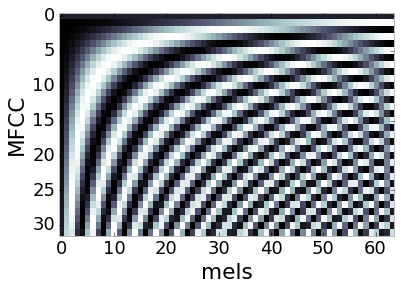

In [144]:
n_mfcc = int(n_mels/2)

dct_filt = lb.filters.dct( n_mfcc, n_mels)

print(log_mel_spec_y.shape[0],
      np.shape(dct_filt),
      "\nNFFT:", NFFT,
      "\n#mels:", n_mels,
      "\n#ceps:", n_mfcc)

# visualise matrix
matplotlib.rcParams['axes.grid']=False
plt.imshow(dct_filt, aspect='auto', interpolation='nearest', cmap=plt.cm.bone_r)
plt.xlabel('mels')
plt.ylabel('MFCC')
oFig = os.path.join(oDir, 'DC-filter.png')
plt.savefig(oFig, bbox_inches='tight')

Apply the filter to the mel-spectrum and get the **MFCC**


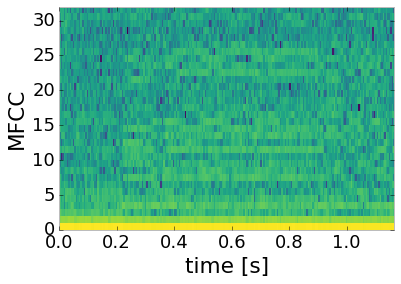

In [145]:
log_mel_spec_y = lb.core.logamplitude(mel_spec_y)

mfcc_y = np.dot(dct_filt, log_mel_spec_y)
plt.imshow(lb.core.logamplitude(mfcc_y[:,:]), aspect='auto', 
           origin='bottom', interpolation='nearest', cmap=plt.cm.viridis,
           extent=[0, tf, 0, n_mfcc])

plt.xlabel('time [s]')
plt.ylabel('MFCC')


oFig = os.path.join(oDir, 'MFCCeptrogram.png')
plt.savefig(oFig, bbox_inches='tight')

In [ ]:
plt.imshow(lb.core.logamplitude(mfcc_y[:,:]), aspect='auto', origin='bottom', interpolation='nearest')
oFig = os.path.join(oDir, 'DC-filter.png')
fig.savefig(oFig, bbox_inches='tight')

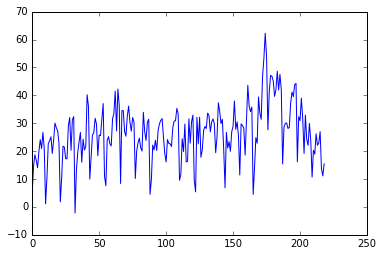

In [18]:
plt.plot(mfcc_y[1,:])

## Cepstrogram

In [147]:
np.shape(log_spec_y)

(257, 219)

64 (32, 257) 
NFFT: 512 
#cepstral coefficients: 32


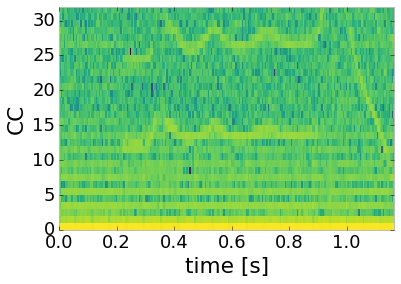

In [153]:
dct_filt = lb.filters.dct( n_mfcc, len(log_spec_y))
n_fcc = len(dct_filt)

print(log_mel_spec_y.shape[0],
      np.shape(dct_filt),
      "\nNFFT:", NFFT,
      "\n#cepstral coefficients:", n_fcc)

log_spec_y = lb.core.logamplitude(spec_y)

mfcc_y = np.dot(dct_filt, log_spec_y)
plt.imshow(lb.core.logamplitude(
            mfcc_y[:,:]), aspect='auto', 
           origin='bottom', interpolation='nearest', cmap=plt.cm.viridis,
           extent=[0, tf, 0, n_fcc])

plt.xlabel('time [s]')
plt.ylabel('CC')


oFig = os.path.join(oDir, 'CCepstrogram.png')
#plt.savefig(oFig, bbox_inches='tight')

## Onset detection --> clicks

In [19]:
onset_frames = lb.onset.onset_detect(y, sr)
timeOnsets = lb.frames_to_time(onset_frames, sr)

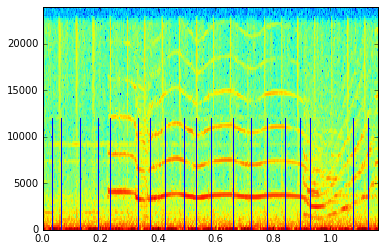

In [20]:
NFFT = 2**8
overlap = 0.5
spec_y, n_fft = lb.core.spectrum._spectrogram(y, n_fft=NFFT, 
                                              hop_length=int(NFFT*overlap))

plt.imshow(lb.core.logamplitude(spec_y), aspect='auto', origin='bottom', interpolation='nearest',
          extent=[0, tf, 0, sr/2])

for to in timeOnsets[:]:
    plt.axvline(to, ymax=0.50)#, ymin=1000)

In [27]:
sc = lb.feature.spectral_centroid(y, sr )
print(np.shape(sc))
sc = lb.feature.spectral_bandwidth(y, sr )
print(np.shape(sc))
sc = lb.feature.melspectrogram(y, sr )
print(np.shape(sc))

(1, 110)
(1, 110)
(128, 110)


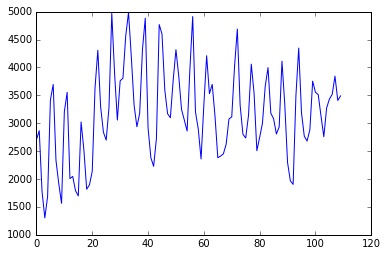

In [25]:
plt.plot(sc[0])